# IE343 -- Statistical Machine Learning and Its Applications
## Lab 5: Linear Model Selection and Regularization
### [Lab 5-1: Subset Selection Methods](#5-1:-Subset-Selection-Methods)
- [1.1. Best Subset Selection](#1.1.-Best-Subset-Selection)
- [1.2. Forward and Backward Stepwise Selection](#1.2.-Forward-and-Backward-Stepwise-Selection)
- [1.3. Choosing Among Models Using the Validation Set Approach and Cross-Validation](#1.3.-Choosing-Among-Models-Using-the-Validation-Set-Approach-and-Cross-Validation)

### [Lab 5-2: Ridge Regression and the Lasso](#5-2:-Ridge-Regression-and-the-Lasso)
- [2.1. Ridge Regression](#2.1.-Ridge-Regression)
- [2.2. The Lasso](#2.2.-The-Lasso)

### [Lab 5-3: PCR and PLS Regression](#5-3:-PCR-and-PLS-Regression)
- [3.1. Principal Components Regression](#3.1.-Principal-Components-Regression)
- [3.2. Partial Least Squares](#3.2.-Partial-Least-Squares)

**Note that the code in this notebook is mostly adapted from [this github repository.](https://github.com/mscaudill/IntroStatLearn/tree/master/notebooks/Ch6_Linear_Model_Selection_Regularization)

In [1]:
# perform standard imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy

from tqdm import tqdm # a python package that provides progress bars for iterables
from operator import itemgetter
from itertools import combinations
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load Dataset

The 'Hitters' dataset contains statistics for baseball players and their salaries. Some of the rows have missing data. We need to locate these rows and drop them from the dataframe.

In [2]:
hitters = pd.read_csv('Hitters.csv')

# Get the number of players  and the number of players with missing values
print('Hitters contains {} players'.format(len(hitters)))
num_missing = np.sum(hitters.isnull().any(axis=1))
print('We are missing data for {} players'.format(num_missing))

# now remove the missing players for dataframe
hitters = hitters.dropna()
print('After removal Hitters contains {} players'.format(len(hitters)))
print('Shape={}'.format(hitters.shape))
hitters.head()

Hitters contains 322 players
We are missing data for 59 players
After removal Hitters contains 263 players
Shape=(263, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Notice that columns League, Division and NewLeague are categorical. We will need to make dummy variables for these.

In [3]:
# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
dummies.head(2)

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0


In [4]:
# Generate new dataframe with new dummy variables
df = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
# add new dummy variables
df = pd.concat([df, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)
df.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0


## 5-1: Subset Selection Methods

**Subset selection:** We identify a subset of the $p$ predictors that we believe to be related to the response. We then fit a model using least squares on the reduced set of variables. 

Which variables to keep and which to drop?

- [1.1. Best Subset Selection](#1.1.-Best-Subset-Selection)
- [1.2. Forward and Backward Stepwise Selection](#1.2.-Forward-and-Backward-Stepwise-Selection)
- [1.3. Choosing Among Models Using the Validation Set Approach and Cross-Validation](#1.3.-Choosing-Among-Models-Using-the-Validation-Set-Approach-and-Cross-Validation)

### 1.1. Best Subset Selection
- Idea
    - Exhaust all possible combinations of inputs
    - With $p$ variables, there are $2^p$ many distinct combinations.
    - Identify the best model among these models.

<div>
<img src="figures/best_subset.png" width="500"/>
</div>

- Advantage: Simple, easy to implement and conceptually clear.
- Disadvantage
    - 1. Computationally expensive
        - With $p$ variables, there are $2^p$ many distinct combinations
    - 2. Statistical problems when 𝑝 is large (Overfitting)
        - Larger the search space, the higher the chance of finding models that look good on the training data, even though they might not have any predictive power on future data.

In [5]:
def best_subsets(dataframe, predictors, response, max_features=8):
    """
    Regresses response onto subsets of the predictors in dataframe. Compares models with equal feature 
    numbers choosing the one with the lowest RSS as the 'best' model for that number of features.
    
    PARAMETERS
    ----------
    dataframe : pandas dataframe obj containing responses and predictors
    predictors : list of column names of dataframe used as features
    response : list of column name of dataframe used as target
    
    RETURNS
    -------
    a list of best models, one per feature number
    
    ex.
    [best 1 feat model, best two feat model] = best_subsets(df, predictors, response, max_features = 2)
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Regression Model of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(dataframe[features])
        y = dataframe[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def get_best_kth_model(k):
        """
        Returns the model from all models with k-predictors with the lowest RSS.
        """
        results = []

        for combo in combinations(predictors, k):
            # process linear model with this combo of features
            results.append(process_linear_model(list(combo)))

        # sort the models and return the one with the smallest RSS
        return sorted(results, key=itemgetter(1)).pop(0)[0]
    
    models =[]
    for k in tqdm(range(1,max_features+1)):
        models.append(get_best_kth_model(k))
    
    return models

In [6]:
# call our best_subsets function
predictors = list(df.columns)
predictors.remove('Salary')
models = best_subsets(df, predictors, ['Salary'], max_features=3)

100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


In [7]:
# The best two variable model has CRBI and Hits as predictors
models[1].params

const   -47.955902
Hits      3.300845
CRBI      0.689899
dtype: float64

### Plot Best Models for Each Predictor Number

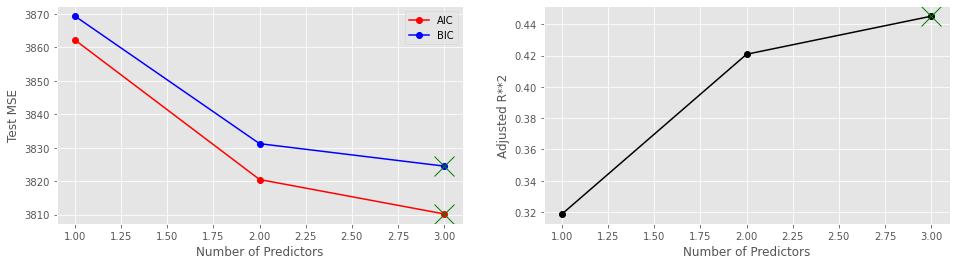

In [8]:
# Now that we have the best models for a given number of varaibles we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model for baseball player salary.
aics = [models[x].aic for x in range(len(models))]
bics = [models[x].bic for x in range(len(models))]
r_adj = [models[x].rsquared_adj for x in range(len(models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
# Add test MSE estimates
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

Recall from lecture 5,
- $C_{p}=\frac{1}{n}\left(R S S+2 d \hat{\sigma}^{2}\right)$
- $A I C=\frac{1}{n \hat{\sigma}^{2}}\left(R S S+2 d \hat{\sigma}^{2}\right)$
- $B I C=\frac{1}{n}\left(R S S+\log (n) d \hat{\sigma}^{2}\right)$ --> <font color='red'>**Severe penalty for large models!**</font>

In [9]:
# The Lowest BIC model has the following coeffecients
models[2].params

const     -71.459220
Hits        2.803816
CRBI        0.682528
PutOuts     0.273581
dtype: float64

### 1.2. Forward and Backward Stepwise Selection
#### 1.2.1. Forward Stepwise Selection
- Idea
    - Begin with a model containing no predictors, and then add predictors to the model, one-at-a-time, until all of the predictors are in the model.
    - At each step the variable that gives the greatest additional improvement to the fit is added to the model.
    
<div>
<img src="figures/forward_stepwise.png" width="700"/>
</div>

- Advantage: 
    - 1. Computationally efficient
        - Only need to consider $1+\sum_{k=0}^{p-1}(p-k)=1+\frac{p(p+1)}{2}$
        - When 𝑝=20
            - Best subset selection: $2^{20}=1,048,576$ models
            - Forward Stepwise selection: $1+\frac{20(20+1)}{2}=211$ models
    - 2. Can work for even in the high-dimensional setting i.e., $n<p$
        - But, it is possible to construct submodels $𝑀_0,…,𝑀_{𝑛−1}$ only, since each submodel is fit using least squares, which will not yield a unique solution if $n<p$
        
- Disadvantage
    - Not guaranteed to find the best subset (Once an input is in, it does not get out)
    
<div>
<img src="figures/forward_stepwise_drawback.png" width="500"/>
</div>

In [10]:
import pdb
def forward_step_select(df, predictors, response, max_features=len(predictors)):
    """
    Regresses response onto predictors using a forward step algorithm. Features are added based on minimum RSS.
    
    PARAMETERS
    -----------
    df : dataframe containing predictors and responses
    predictors : list of all possible model predictors
    response : list[variable] to regress onto predictors in df
    max_features : maximum number of features to use from predictors list
    
    RETURNS
    --------
    list of models with increasing number of features upto max_features
    
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features, remaining_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
        
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:        
        # get the best new feature set from update_model
        new_features, new_model = update_model(best_features, remaining_features)
        # update the best features to include the one we just found
        best_features = new_features  
        # reduce the available features for the next round
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        # append the new_features and model so we can compare models with different features later
        models.append((new_features,new_model))
        
    return models

In [11]:
# Call our forward step function
# set up inputs
predictors = list(df.columns)
predictors.remove('Salary')
# call forward_step_select
mods = forward_step_select(df,predictors,['Salary'],max_features=19)

In [12]:
mods[6][1].params # The seventh models features agree with regsubsets fwd result from lab.

const         109.787306
CRBI            0.853762
Hits            7.449877
PutOuts         0.253340
Division_W   -127.122393
AtBat          -1.958885
Walks           4.913140
CWalks         -0.305307
dtype: float64

#### 1.2.2. Backward Stepwise Selection
- Like forward stepwise selection, backward stepwise selection provides an efficient alternative to best subset selection.
- However, unlike forward stepwise selection, it begins with the full least squares model containing all $p$ predictors, and then iteratively removes the least useful predictor, one-at-a-time.

<div>
<img src="figures/backward_stepwise.png" width="700"/>
</div>

- Advantage: Computational efficiency
    - Same as forward stepwise selection
- Disadvantage
    - 1) Not guaranteed to find the best subset (like forward stepwise selection)
        - Once an input is out, it does not get in.
    - 2) Cannot work for $n<p$ 
        - We start with the model with all $p$ predictors

<font color='red'>**Try to implement yourself**</font>

Hint: Backwards subset selection works very similarly to forward except we remove features in the update_model function based on the feature which reduces the RSS the most.

### 1.3. Choosing Among Models Using the Validation Set Approach and Cross-Validation

### Validation: Train/Test Split

We start by splitting the data into a train set and a test set to perform validation.

In [13]:
# create an index to break the hitters dataframe into a train and test set that are roughly equal in size
np.random.seed(0)
index = np.random.choice([True, False], size=len(df))

# split the data into train and validation sets
df_train = df[index]
df_test = df[~index]

### Construct models from the Train Set

In [14]:
# Now we construct models from the training set selecting the best models using our best_subsets function
predictors = list(df_train.columns)
predictors.remove('Salary')
models = forward_step_select(df_train, predictors, ['Salary'], max_features=19)

### Evaluate MSE of Models on Validation Set

In [15]:
# now for each of the models we will perform prediction and get MSE on the test data
mses = np.array([])
for model in models:
    # get the predictors for this model, ignore constant
    features = list(model[1].params.index[1:])
    
    # get the corresponding columns of df_test
    X_test = sm.add_constant(df_test[features])
    
    # make prediction for this model
    salary_pred = model[1].predict(X_test)
    
    # get the MSE for this model
    mses = np.append(mses, np.mean((salary_pred - df_test.Salary.values)**2))
print('MSEs =', mses)

MSEs = [197453.6869 174455.6938 171032.0227 157148.6279 160632.673  153558.7767
 152983.229  153873.0514 150133.6039 150855.2866 153924.5203 158212.0204
 159706.1481 160150.8428 155067.9795 155263.8078 157272.7422 156868.3555
 156763.4384]


### Determine the Best Model (lowest Test MSE)

In [16]:
min_index, min_mse = min(enumerate(mses), key=itemgetter(1))
print(min_index, min_mse)

8 150133.60393975192


In [17]:
print('9-Variable Model:', list(models[7][1].params.index))

9-Variable Model: ['const', 'CHmRun', 'Hits', 'PutOuts', 'CRuns', 'CAtBat', 'AtBat', 'League_N', 'NewLeague_N']


### Plot MSEs 

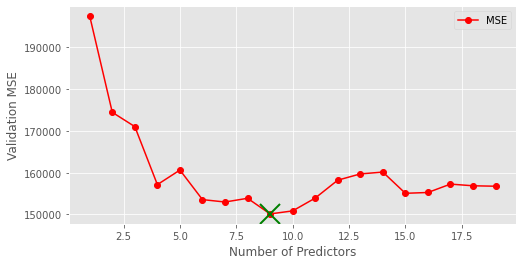

In [18]:
# We can also plot all the models MSEs
# set predictors for x-axis
num_predictors = np.linspace(1,len(models),len(models)).astype(int)

fig, ax1 = plt.subplots(figsize=(8,4));

# add the mse and mimimum mse to the plot
ax1.plot(num_predictors, mses, 'r', marker='o', label='MSE')
ax1.plot(min_index+1, min_mse, 'gx', markersize=20, markeredgewidth=2)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Validation MSE');
ax1.legend(loc='best');

## Cross-Validation Model Selection

For Cross-Validation we will split the data into 10-folds. For each fold, we will compute the best models, one per model dimension where the dimension is from one feature to all features. So in total we will have the MSE for 19 models in each of the 10 folds. We will average the MSEs across folds to get the Cross-Validation Test MSE.

In [19]:
# Create the 10 folds using sklearn KFolds
kf = KFold(n_splits=10, random_state=1)

mses = np.zeros([10, len(predictors)])

for fold, (train, test) in enumerate(kf.split(df)):
    # split data for this fold
    df_train = df.iloc[train]
    df_test = df.iloc[test]
    
    # compute the best model subsets using our function
    models = forward_step_select(df_train, predictors, ['Salary'], max_features=19)
    
    # compute the MSE of each model
    for idx, model in enumerate(models):
        # get the predictors for this model, ignore constant
        features = list(model[1].params.index[1:])
    
        # get the corresponding columns of df_test
        X_test = sm.add_constant(df_test[features])
    
        # make prediction for this model
        salary_pred = model[1].predict(X_test)
    
        # get the MSE for this model and fold
        mses[fold, idx] = np.mean((salary_pred - df_test.Salary.values)**2)
        
# now we can compute the mean MSE across folds, one per model with idx features
cvs = np.mean(mses, axis=0) 

C:\Users\Mark Mintae Kim\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


### Plot Cross-Validation Errors

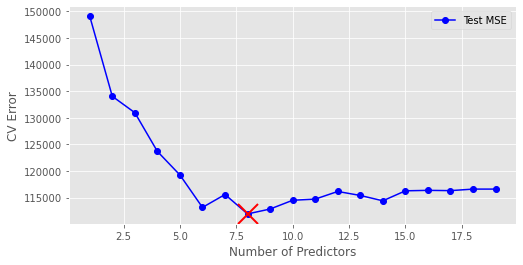

In [20]:
# We can also plot all the models CV-Errors
# set predictors for x-axis
num_predictors = np.linspace(1,len(models),len(models))

fig, ax1 = plt.subplots(figsize=(8,4));

# get the minimum in the CV
min_index, min_CV = min(enumerate(cvs), key=itemgetter(1))

# add the mse and mimimum mse to the plot
ax1.plot(num_predictors, cvs, 'b', marker='o', label='Test MSE')
ax1.plot(min_index+1, min_CV, 'rx', markersize=20, markeredgewidth=2)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('CV Error');
ax1.legend(loc='best');

## 5-2: Ridge Regression and the Lasso
- Shrinkage methods
    - The subset selection methods use least squares to fit a linear model that contains a subset of the predictors
    - Shrinkage methods use all $p$ predictors, but constrain or regularizes the coefficient estimates, or equivalently shrink the coefficient estimates to zero
    - It turns out that shrinking estimated coefficients towards zero can significantly reduce their variance
    - Two best-known techniques are ridge regression and lasso

<div>
<img src="figures/regressions.png" width="700"/>
</div>

<div>
<img src="figures/ridge_lasso.png" width="700"/>
</div>

In [21]:
hitters = pd.read_csv('Hitters.csv').dropna()
hitters = hitters.reset_index(drop=True)
hitters.index.name = 'Player'

hitters = hitters.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]] # push salary at the end

In [22]:
hitters.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague,Salary
Player,,,,,,,,,,,,,,,,,,,,
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,N,475.0
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,A,480.0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,N,500.0
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,N,91.5
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,A,750.0


In [23]:
hitters['League'] = pd.get_dummies(hitters['League']).iloc[:, 1]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:, 1]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:, 1]
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague,Salary
Player,,,,,,,,,,,,,,,,,,,,
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,1,475.0
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,0,480.0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,1,500.0
3,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,1,91.5
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,0,750.0


In [24]:
X = hitters.iloc[:, 0:19]
y = hitters.iloc[:, 19]

### 2.1. Ridge Regression

In [25]:
# standardization
#from sklearn.preprocessing import scale

#X_scaled = scale(X)

In [26]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from numpy import linalg
from sklearn.metrics import mean_squared_error
lambdas = 10 ** np.linspace(-4,10,100)

ridge_model = Ridge(normalize=True)
coefs = []
MSE = []

for a in lambdas:
    ridge_model.set_params(alpha=a)
    ridge_model.fit(X, y)
    coefs.append(ridge_model.coef_)
    MSE.append(mean_squared_error(y, ridge_model.predict(X)))

In [27]:
lambdas

array([1.0000e-04, 1.3849e-04, 1.9179e-04, 2.6561e-04, 3.6784e-04,
       5.0941e-04, 7.0548e-04, 9.7701e-04, 1.3530e-03, 1.8738e-03,
       2.5950e-03, 3.5938e-03, 4.9770e-03, 6.8926e-03, 9.5455e-03,
       1.3219e-02, 1.8307e-02, 2.5354e-02, 3.5112e-02, 4.8626e-02,
       6.7342e-02, 9.3260e-02, 1.2915e-01, 1.7886e-01, 2.4771e-01,
       3.4305e-01, 4.7508e-01, 6.5793e-01, 9.1116e-01, 1.2619e+00,
       1.7475e+00, 2.4201e+00, 3.3516e+00, 4.6416e+00, 6.4281e+00,
       8.9022e+00, 1.2328e+01, 1.7074e+01, 2.3645e+01, 3.2745e+01,
       4.5349e+01, 6.2803e+01, 8.6975e+01, 1.2045e+02, 1.6681e+02,
       2.3101e+02, 3.1993e+02, 4.4306e+02, 6.1359e+02, 8.4975e+02,
       1.1768e+03, 1.6298e+03, 2.2570e+03, 3.1257e+03, 4.3288e+03,
       5.9948e+03, 8.3022e+03, 1.1498e+04, 1.5923e+04, 2.2051e+04,
       3.0539e+04, 4.2292e+04, 5.8570e+04, 8.1113e+04, 1.1233e+05,
       1.5557e+05, 2.1544e+05, 2.9836e+05, 4.1320e+05, 5.7224e+05,
       7.9248e+05, 1.0975e+06, 1.5199e+06, 2.1049e+06, 2.9151e

In [28]:
pd.Series(coefs[0], index=X.columns)

AtBat         -1.976767
Hits           7.466361
HmRun          4.224929
Runs          -2.320085
RBI           -1.011988
Walks          6.213859
Years         -3.684739
CAtBat        -0.168723
CHits          0.141298
CHmRun        -0.132810
CRuns          1.429807
CRBI           0.789405
CWalks        -0.806568
League        62.626843
Division    -117.003890
PutOuts        0.281895
Assists        0.369688
Errors        -3.373104
NewLeague    -24.946913
dtype: float64

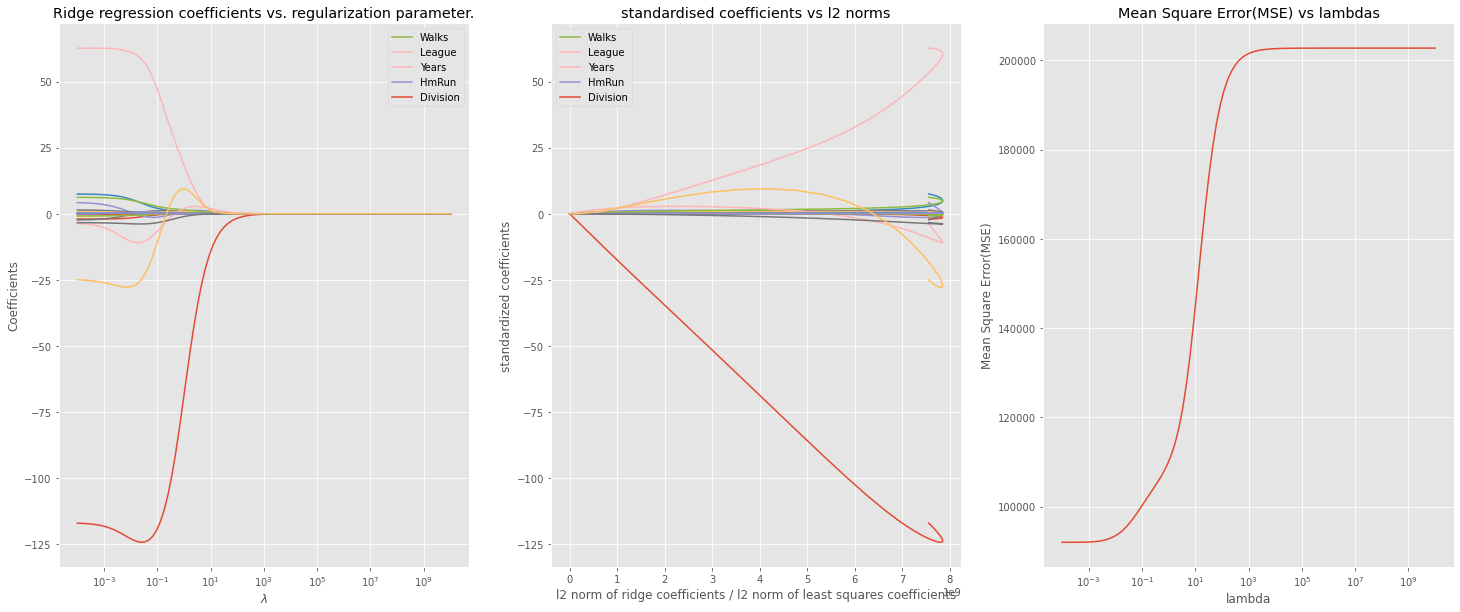

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,10))

idx = np.argpartition(np.abs(coefs[-1]), -5)[-5:] # To get 5 predictors with highest coefficients when lambda is the highest
# standardised coefficients vs lambdas
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
# plt.axis('tight')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel('Coefficients');
ax1.set_title('Ridge regression coefficients vs. regularization parameter.');
ax1.legend(np.array(ax1.get_lines())[idx], X.columns[idx])


# standardised coefficients vs l2 norms
l2norm = linalg.norm(coefs[-1])
l2coefs = linalg.norm(coefs/l2norm, axis=1)
ax2.plot(l2coefs, coefs)
ax2.set_xlabel('l2 norm of ridge coefficients / l2 norm of least squares coefficients')
ax2.set_ylabel('standardized coefficients')
ax2.set_title('standardised coefficients vs l2 norms')
ax2.legend(np.array(ax2.get_lines())[idx], X.columns[idx]);

# 'Mean Square Error(MSE) vs lambdas
ax3.plot(lambdas, MSE)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('Mean Square Error(MSE)')
ax3.set_title('Mean Square Error(MSE) vs lambdas');


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [31]:
# "good" ridge model
ridge2 = Ridge(alpha=4, normalize=True)
ridge2.fit(X_train, y_train)
y_pred2 = ridge2.predict(X_test)

print(pd.Series(ridge2.coef_, index=X.columns))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred2)))

AtBat         0.098658
Hits          0.446094
HmRun         1.412107
Runs          0.660773
RBI           0.843403
Walks         1.008473
Years         2.779882
CAtBat        0.008244
CHits         0.034149
CHmRun        0.268634
CRuns         0.070407
CRBI          0.070060
CWalks        0.082795
League        4.241051
Division    -30.768885
PutOuts       0.104747
Assists      -0.003739
Errors        0.268363
NewLeague     4.123474
dtype: float64
MSE: 106216.52238005561


In [32]:
# very high lambda
ridge3 = Ridge(alpha=1e10, normalize=True)
ridge3.fit(X_train, y_train)
y_pred3 = ridge3.predict(X_test)

print(pd.Series(ridge3.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred3))

AtBat        1.317464e-10
Hits         4.647486e-10
HmRun        2.079865e-09
Runs         7.726175e-10
RBI          9.390640e-10
Walks        9.769219e-10
Years        3.961442e-09
CAtBat       1.060533e-11
CHits        3.993605e-11
CHmRun       2.959428e-10
CRuns        8.245247e-11
CRBI         7.795451e-11
CWalks       9.894387e-11
League      -2.501281e-09
Division    -1.549951e-08
PutOuts      7.268991e-11
Assists     -2.615885e-12
Errors       2.084514e-10
NewLeague   -2.023196e-09
dtype: float64
MSE: 172862.23580379886


In [33]:
# lambda=0 -> OLS
ridge4 = Ridge(alpha=0, normalize=True)
ridge4.fit(X_train, y_train)
y_pred4 = ridge4.predict(X_test)

print(pd.Series(ridge4.coef_, index=X.columns))
print('MSE:', mean_squared_error(y_test, y_pred4))

AtBat         -1.821115
Hits           4.259156
HmRun         -4.773401
Runs          -0.038760
RBI            3.984578
Walks          3.470126
Years          9.498236
CAtBat        -0.605129
CHits          2.174979
CHmRun         2.979306
CRuns          0.266356
CRBI          -0.598456
CWalks         0.171383
League       133.743163
Division    -113.743875
PutOuts        0.421063
Assists        0.464379
Errors        -6.024576
NewLeague    -81.927763
dtype: float64
MSE: 116690.46856660435


In [34]:
# cross validated ridge (10-fold)
kf = KFold(n_splits=10, random_state=1)
ridge_cv = RidgeCV(alphas=lambdas, normalize=True, scoring='neg_mean_squared_error', cv=kf)
ridge_cv.fit(X_train, y_train)
print('Best lambda= {:.4f}'.format(ridge_cv.alpha_))

C:\Users\Mark Mintae Kim\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Best lambda= 0.6579


C:\Users\Mark Mintae Kim\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


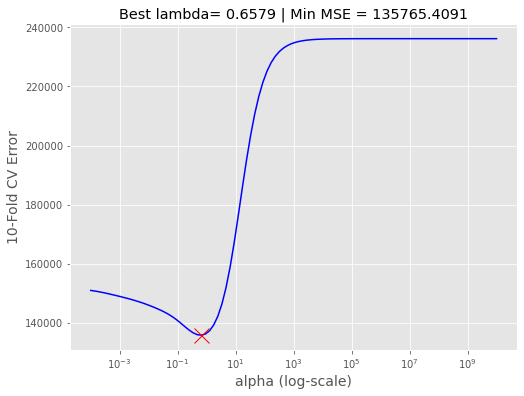

In [35]:
# Create the 10 folds using sklearn KFolds
kf = KFold(n_splits=10, random_state=1)

# Manually showing the process of K-fold cross validation
cvs = []
import pdb

for alpha in lambdas:
    # For each shrinkage factor compute the models MSE for the 10-folds
    error = []
    
    for train, test in kf.split(X_train):
        # get test/train splits
        X_train_ = X_train.iloc[train]
        y_train_ = y_train.values[train]
        X_test_ = X_train.iloc[test]
        y_test_ = y_train.values[test]
        
        # build model for each split
        model = Ridge(alpha=alpha, normalize=True).fit(X_train_,y_train_)
        # compute error for this each response at this alpha for this fold
        error = np.append(error,(model.predict(X_test_)-y_test_))
        
    # compute mean squared error for this alpha
    cvs = np.append(cvs,np.mean(error**2))

# get the minimum alpha
min_index, min_cvs = min(enumerate(cvs), key=itemgetter(1)) 

# Plot the CV Errors as a funtion of alpha and plot minimum
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(lambdas, cvs, color='b')
ax.plot(lambdas[min_index], min_cvs, marker='x', color='r', markersize=15)

ax.set_xscale('log')
ax.set_ylabel('10-Fold CV Error', fontsize=14);
ax.set_xlabel('alpha (log-scale)', fontsize=14);
ax.set_title('Best lambda= {:.4f} | Min MSE = {:.4f}'.format(lambdas[min_index], min_cvs));

In [36]:
# Using the best lambda
ridge5 = Ridge(alpha=ridge_cv.alpha_, normalize=True)
ridge5.fit(X_train, y_train)
y_pred5 = ridge5.predict(X_test)

print(pd.Series(ridge5.coef_, index=X.columns))
print("[Ridge] Test set MSE = ", mean_squared_error(y_test, y_pred5))

AtBat         0.007004
Hits          0.820565
HmRun        -0.038859
Runs          0.738681
RBI           1.281625
Walks         2.006648
Years         1.490860
CAtBat        0.007236
CHits         0.050842
CHmRun        0.491202
CRuns         0.104461
CRBI          0.123140
CWalks        0.101208
League       17.712645
Division    -88.016788
PutOuts       0.267455
Assists      -0.017627
Errors       -0.220421
NewLeague    10.260829
dtype: float64
[Ridge] Test set MSE =  99691.75835893235


### 2.2. The Lasso

In [37]:
from sklearn.linear_model import Lasso, LassoCV

lambdas = 10 ** np.linspace(-4,10,100)

lasso_model = Lasso(normalize=True, max_iter=10000) # max_iter=10000 for removing ConvergenceWarning
coefs = []
MSE = []

for a in lambdas:
    lasso_model.set_params(alpha=a)
    lasso_model.fit(X, y)
    coefs.append(lasso_model.coef_)
    MSE.append(mean_squared_error(y, lasso_model.predict(X)))

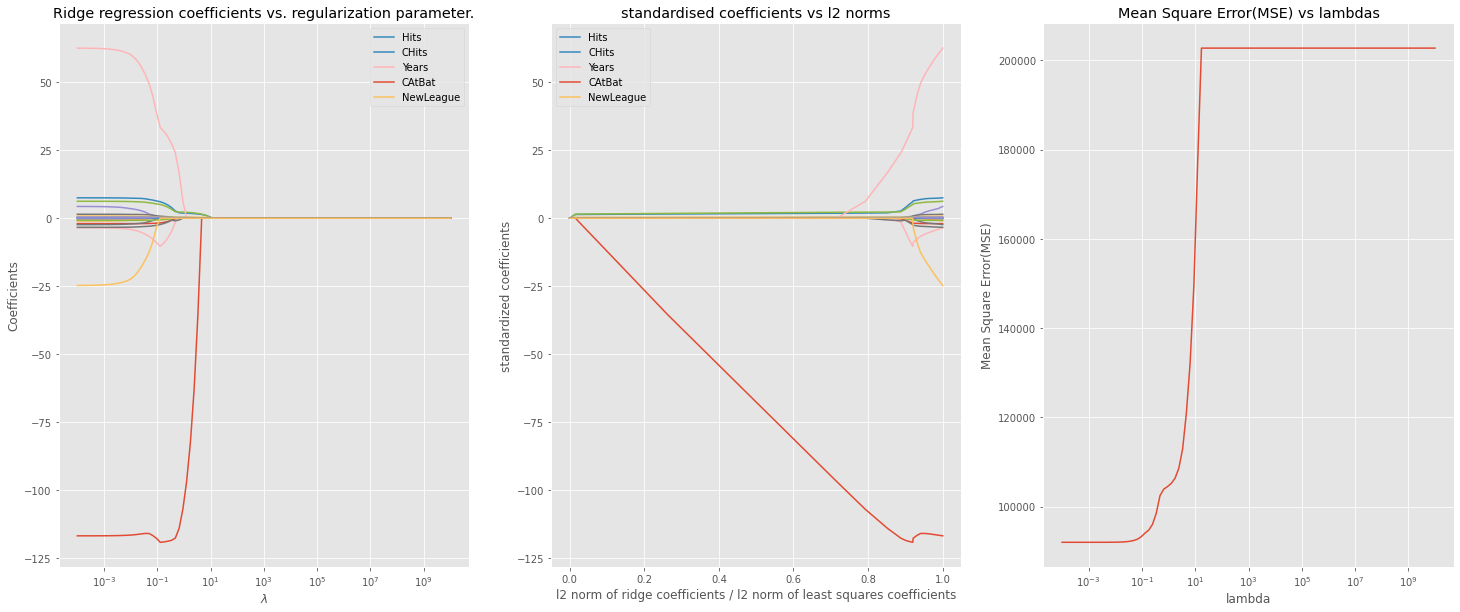

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,10))

idx = np.argpartition(np.abs(coefs[-1]), -5)[-5:]
# standardised coefficients vs lambdas
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
# plt.axis('tight')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel('Coefficients');
ax1.set_title('Ridge regression coefficients vs. regularization parameter.');
ax1.legend(np.array(ax1.get_lines())[idx], X.columns[idx])
# ax1.legend(X.columns.tolist(),loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6);


# standardised coefficients vs l2 norms
l2norm = linalg.norm(coefs[0])
l2coefs = linalg.norm(coefs/l2norm, axis=1)
ax2.plot(l2coefs, coefs)
ax2.set_xlabel('l2 norm of ridge coefficients / l2 norm of least squares coefficients')
ax2.set_ylabel('standardized coefficients')
ax2.set_title('standardised coefficients vs l2 norms')
ax2.legend(np.array(ax2.get_lines())[idx], X.columns[idx]);

# 'Mean Square Error(MSE) vs lambdas
ax3.plot(lambdas, MSE)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('Mean Square Error(MSE)')
ax3.set_title('Mean Square Error(MSE) vs lambdas');

In [39]:
# cross validated lasso (10-fold)
lasso_cv = LassoCV(alphas=lambdas, normalize=True, cv=kf, max_iter=100000)
lasso_cv.fit(X_train, y_train)
print('Best lambda= {:.4f}'.format(lasso_cv.alpha_))

Best lambda= 2.4201


In [40]:
# Using the best lambda
lasso = Lasso(alpha=lasso_cv.alpha_, normalize=True)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

print(pd.Series(lasso.coef_, index=X.columns))
print("[Lasso] Test set MSE = ", mean_squared_error(y_test, y_pred))

AtBat         0.000000
Hits          1.080923
HmRun         0.000000
Runs          0.000000
RBI           0.000000
Walks         2.903215
Years         0.000000
CAtBat        0.000000
CHits         0.000000
CHmRun        0.218493
CRuns         0.000000
CRBI          0.513754
CWalks        0.000000
League        0.000000
Division    -88.685399
PutOuts       0.368081
Assists      -0.000000
Errors       -0.000000
NewLeague     0.000000
dtype: float64
[Lasso] Test set MSE =  104972.96754895902


### Ridge vs Lasso

In [41]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from numpy import linalg
from sklearn.metrics import mean_squared_error
lambdas = 10 ** np.linspace(-4,10,100)

ridge_model = Ridge(normalize=True)
lasso_model = Lasso(normalize=True, max_iter=10000) # max_iter=10000 for removing ConvergenceWarning

ridge_coefs = []
ridge_MSE = []
lasso_coefs = []
lasso_MSE = []

for a in lambdas:
    ridge_model.set_params(alpha=a)
    ridge_model.fit(X, y)
    ridge_coefs.append(ridge_model.coef_)
    ridge_MSE.append(mean_squared_error(y, ridge_model.predict(X)))
    
    lasso_model.set_params(alpha=a)
    lasso_model.fit(X, y)
    lasso_coefs.append(lasso_model.coef_)
    lasso_MSE.append(mean_squared_error(y, lasso_model.predict(X)))

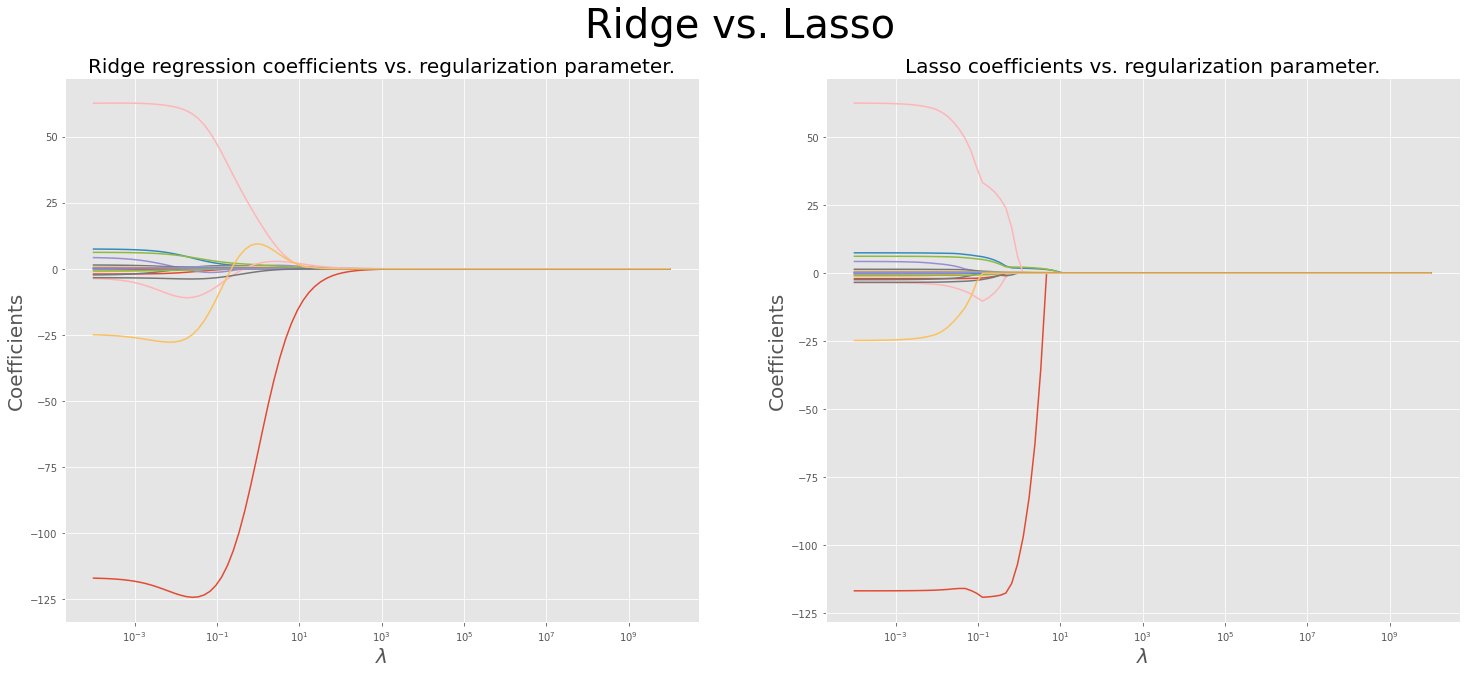

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,10))

ax1.plot(lambdas, ridge_coefs)
ax1.set_xscale('log')
ax1.set_xlabel(r'$\lambda$', fontsize=20)
ax1.set_ylabel('Coefficients', fontsize=20);
ax1.set_title('Ridge regression coefficients vs. regularization parameter.', fontsize=20)

ax2.plot(lambdas, lasso_coefs)
ax2.set_xscale('log')
ax2.set_xlabel(r'$\lambda$', fontsize=20)
ax2.set_ylabel('Coefficients', fontsize=20);
ax2.set_title('Lasso coefficients vs. regularization parameter.', fontsize=20);

fig.suptitle("Ridge vs. Lasso", fontsize=40);

## 5-3: PCR and PLS Regression

The methods that we have discussed so far have controlled variance in two different ways
- 1. **Subset selection** 
    - i.e., Best subset selection, Forward-, and Backward- stepwise selection
    - Selecting subset of variables
- 2. **Shrinkage method** 
    - i.e., Ridge and Lasso
    - Shrinking the estimated coefficients toward zero
    
All of these methods are defined using the original predictors $X_1, ..., X_p$.

<font color='red'><b>What if not all p dimensions are equally useful?</b></font> --> We perform <font color='green'>dimension reduction.</font>

<div>
<img src="figures/dim_reduction.png" width="500"/>
</div>

We use <font color='red'>Principal Components Analysis (PCA)</font> to get $\boldsymbol{\phi} \in \mathbb{R}^{p \times M}$

In [43]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

hitters = pd.read_csv('Hitters.csv').dropna()
hitters.index.name = 'Player'

hitters = hitters.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]] # push salary at the end

hitters['League'] = pd.get_dummies(hitters['League']).iloc[:, 1]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:, 1]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:, 1]

X = hitters.iloc[:, 0:19]
y = hitters.iloc[:, 19]

### 3.1. Principal Components Regression

In [44]:
pca = PCA()
X_pca = pca.fit_transform(scale(X))
pd.DataFrame(X_pca)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972,-0.065146,-0.098249,-0.252423,-0.637101,0.459341,0.615860,-0.478088,0.388407,0.063596,0.144790,0.080216,0.038140,-0.019250
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617,0.359893,-1.199383,-0.371820,0.015215,0.176235,0.080529,0.403483,-0.019386,0.065149,0.161064,0.044343,0.014834,-0.003395
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712,-0.999385,0.844247,0.197379,0.770490,0.055645,0.104938,0.021605,-0.376197,0.234291,0.011526,-0.218283,0.037825,-0.066501
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696,-0.276141,0.207094,0.414956,0.136842,-0.085375,-0.146217,0.142172,0.028975,0.042459,0.053043,-0.044443,0.010360,-0.013582
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675,0.140456,0.989707,-0.661933,-0.217565,0.111259,0.191244,-0.302426,-0.090770,0.043811,0.012300,-0.050593,0.126036,-0.071035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,-0.331167,-0.165663,0.775890,-1.536702,-1.035016,-0.306299,0.552371,1.184243,-0.246646,0.379402,-0.094963,-0.033645,0.216773,-0.161802,0.227441,-0.224885,0.126489,-0.055403,-0.009739
259,3.246183,-0.543315,1.209150,2.754023,-1.197520,0.834749,1.969884,-1.371907,-0.543945,-0.897725,-0.166160,-0.298189,0.510572,0.318121,-0.144807,0.008947,-0.152826,-0.053871,-0.062282
260,-1.094609,-0.751386,-0.935937,1.072347,0.705912,-0.644482,1.496147,0.287111,-0.304373,0.017862,0.221392,0.378174,0.016308,0.092282,0.056039,-0.103487,-0.078738,0.067201,0.013194
261,1.977682,-2.184517,-0.282012,-0.216874,-0.694872,3.514692,1.142097,-0.230697,-0.240990,0.324960,0.118597,0.162044,-0.347028,-0.232762,0.021050,-0.262275,-0.014407,0.022921,-0.010530


Percentage of variance explained
- The amount of information about the predictors or the response that is captured using $M$ principal components

In [45]:
explained_variance_ratio = np.var(X_pca, axis=0) / np.sum(np.var(X_pca, axis=0))
EVR = pd.DataFrame(np.cumsum(np.round(explained_variance_ratio, decimals=4)*100), columns=['explained variance ratio'])
EVR.index = EVR.index + 1
EVR

,explained variance ratio
1,38.31
2,60.15
3,70.84
4,79.03
5,84.29
6,88.63
7,92.26
8,94.96
9,96.28
10,97.25


- Setting M = 1 only captures 38.31% of all the variance, or information, in the predictors. 
- Setting M = 6 increases the value to 88.63%. 
- Of course, if we were to use all M = p = 19 components, this would increase to 100%.

### Comparison with the case without performing PCA

In [46]:
explained_variance_ratio_test = np.var(scale(X), axis=0) / np.sum(np.var(scale(X_test), axis=0))
EVR2 = pd.DataFrame(np.cumsum(np.round(explained_variance_ratio_test, decimals=4)*100), columns=['Explained Variance Ratio'])
EVR2.index = EVR2.index + 1
EVR2

,Explained Variance Ratio
1,5.26
2,10.52
3,15.78
4,21.04
5,26.30
6,31.56
7,36.82
8,42.08
9,47.34
10,52.60


This shows the benefit of PCA.

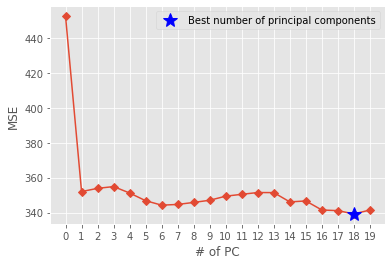

In [47]:
# 10-fold CV
n = len(X_pca)
lin_reg = LinearRegression()
mse = []

# MSE with only the intercept
score = -1 * cross_val_score(LinearRegression(fit_intercept=False), np.ones((n,1)), y, cv=kf, scoring='neg_mean_squared_error').mean()
mse.append(np.sqrt(score))

# MSE for the 19 principle components
for i in np.arange(1, 20):
    score = -1 * cross_val_score(lin_reg, X_pca[:,:i], y, cv=kf, scoring='neg_mean_squared_error').mean()
    mse.append(np.sqrt(score))
    
min_mse = np.array(mse).argmin()
    
plt.plot(mse, '-D')
plt.xlabel('# of PC')
plt.ylabel('MSE');
plt.xticks(range(20), range(20))
min_mse_marker, = plt.plot(min_mse, min(mse), 'b*', markersize=15)
plt.legend([min_mse_marker], ['Best number of principal components']);

### PCR on training data and evaluate its test set performance.

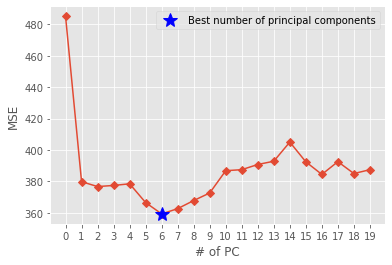

In [48]:
# validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

pca2 = PCA()
X_train_pca2 = pca2.fit_transform(scale(X_train))

# 10-fold CV, with shuffle
n = len(X_train_pca2)

lin_reg2 = LinearRegression()
mse2 = []

# MSE with only the intercept
score = -1 * cross_val_score(lin_reg2, np.ones((n,1)), y_train, cv=kf, scoring='neg_mean_squared_error').mean()
mse2.append(np.sqrt(score))

# MSE for the 19 principle components
for i in np.arange(1, 20):
    score = -1 * cross_val_score(lin_reg2, X_train_pca2[:,:i], y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    mse2.append(np.sqrt(score))

min_mse = np.array(mse2).argmin()
    
plt.plot(mse2, '-D')
plt.xlabel('# of PC')
plt.ylabel('MSE')
plt.xticks(range(20), range(20))
min_mse_marker, = plt.plot(min_mse, min(mse2), 'b*', markersize=15)
plt.legend([min_mse_marker], ['Best number of principal components']);

The lowest cross-validation error occurs when 6 components are used. Next perform PCR on the test data and compute the test MSE.

In [49]:
X_train_pca3 = pca2.fit_transform(scale(X_train))[:, :7]
X_test_pca3 = pca2.fit_transform(scale(X_test))[:, :7]

lin_reg3 = LinearRegression()
lin_reg3.fit(X_train_pca3, y_train)
pred_pca3 = lin_reg3.predict(X_test_pca3)

print("[PCR] Test set MSE = ", mean_squared_error(y_test, pred_pca3))

[PCR] Test set MSE =  114098.05632066297


### 3.2. Partial Least Squares

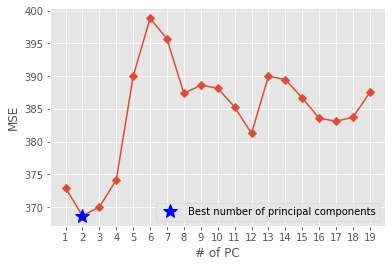

In [50]:
from sklearn.cross_decomposition import PLSRegression

# 10-fold CV
n = len(X_train)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = -1 * cross_val_score(pls, scale(X_train), y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    mse.append(np.sqrt(score))    

min_mse = np.array(mse).argmin()+1
    
plt.plot(range(1,20), mse, '-D')
plt.xlabel('# of PC')
plt.ylabel('MSE')
plt.xticks(range(1,20), range(1,20))
min_mse_marker, = plt.plot(min_mse, min(mse), 'b*', markersize=15)
plt.legend([min_mse_marker], ['Best number of principal components']);

In [51]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)
y_pred = pls.predict(scale(X_test))

print("[PLS] Test set MSE = ", mean_squared_error(y_test, y_pred))

[PLS] Test set MSE =  104838.51042760804


#### Summary
- [Ridge] Test set MSE =  99691.75835893235
- [Lasso] Test set MSE =  104972.96754895902
- [PCR] Test set MSE =  114098.05632066308
- [PLS] Test set MSE =  104838.51042760804